# Imports

In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-06-20 15:21:11.848155: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-06-20 15:21:15.577748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 15:21:16.399356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:99:00.0, compute capability: 8.6


In [3]:
from orbit_generation.constants import EM_MU
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, plot_latent_space_2d
from orbit_generation.stats import plot_histograms_comparison, reduce_dimensions_plot_combined_latent_space, reduce_dimensions_plot_latent_space
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model import get_optimizer, get_model, extract_plot_and_return_metrics
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, convert_notebook, add_experiment_metrics

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-20 15:21:23.320530: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-20 15:21:23.322371: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x78d1d30


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tsgm
import os

# Parameters

In [5]:
want_to_train = True        # Set this parameter to False if you want to load the model from the folder
want_to_generate = True     # Set this parameter to False if you want to load the generation from the folder

In [6]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [7]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 300,
    'val_split': 0.2,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    },
    'num_samples': 100
}

In [8]:
if want_to_train:
    # Initialize a new run
    wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

## Shuffle

In [10]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = np.array(labels)
labels = labels[indices]

## Transpose

In [11]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [12]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(45211, 300, 7)

# Modelling

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-06-20 15:22:21.849654: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   6/1131 [..............................] - ETA: 1:07 - loss: 1693.2608 - reconstruction_loss: 1298.3007 - kl_loss: 3.2130WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0271s vs `on_train_batch_end` time: 0.0285s). Check your callbacks.


1131/1131 [==============================] - 74s 62ms/step - loss: 280.0443 - reconstruction_loss: 154.8936 - kl_loss: 6.3854 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/25
1131/1131 [==============================] - 69s 61ms/step - loss: 105.2477 - reconstruction_loss: 99.2308 - kl_loss: 7.3082 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/25
1131/1131 [==============================] - 70s 62ms/step - loss: 61.6841 - reconstruction_loss: 41.5544 - kl_loss: 7.0121 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/25
1131/1131 [==============================] - 70s 62ms/step - loss: 39.0519 - reconstruction_loss: 27.3233 - kl_loss: 6.9572 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/25
1131/1131 [==============================] - 70s 62ms/step - loss: 32.5774 - reconstr

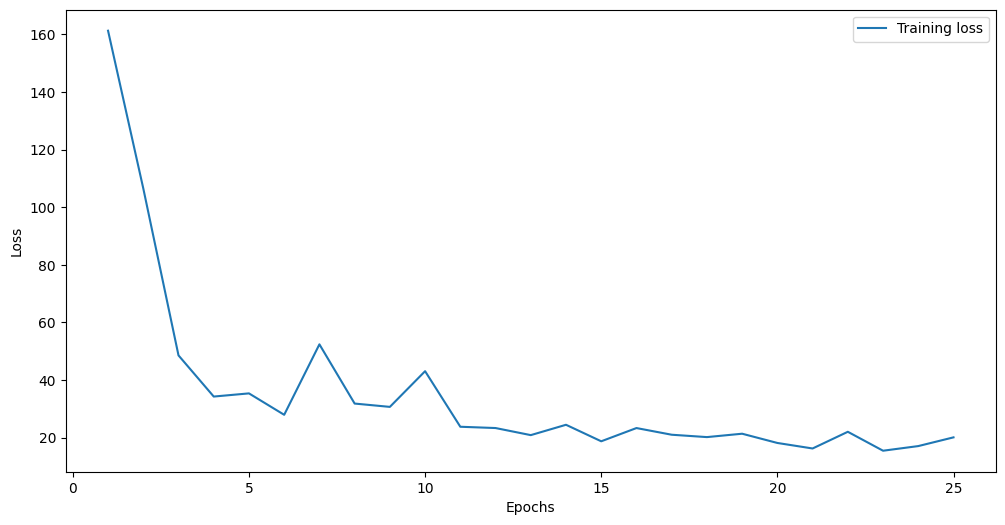

In [13]:
if want_to_train:
    model = get_model(params)
    optimizer = get_optimizer(params['optimizer'])
    
    metrics = {}

    # Compile the model with the configured optimizer from the params dictionary
    model.compile(optimizer=optimizer)

    # Fit the model using the scaled data and parameters from the dictionary
    history = model.fit(
        scaled_data, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_split=params['val_split'],  # Adjust the split ratio as needed
        callbacks=[WandbCallback()]
    )

    # Extract, plot, and return metrics
    training_metrics = extract_plot_and_return_metrics(history, validation=False)

## Saving

In [14]:
experiment_folder = setup_new_experiment(params, experiments_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

New experiment setup complete: ../experiments/experiment_1
Parameters saved to ../experiments/experiments.json.


In [15]:
add_experiment_metrics(experiments_folder, params=params, metrics=training_metrics)

Metrics added to experiment with ID 1 in ../experiments/experiments.json.


In [16]:
# Define full paths for saving

generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
static_all_orbit_path = os.path.join(experiment_folder, f'exp{experiment_id}_all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, f'exp{experiment_id}_some_generated_data.png')
dynamic_orbits_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_latent_representations.npy')
labels_sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_sampled_latent_representations.npy')
latent_space_path = os.path.join(experiment_folder, f'exp{experiment_id}_dimensionality_reduction_latent_space')
combined_latent_space_path = os.path.join(experiment_folder, f'exp{experiment_id}_combined_dimensionality_reduction_latent_space')

In [17]:
if want_to_train:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        model.encoder.save(encoder_save_path, save_format='tf')
        model.decoder.save(decoder_save_path, save_format='tf')
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model.save(model_save_path, save_format='tf')
else:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        encoder = tf.keras.models.load_model(encoder_save_path)
        decoder = tf.keras.models.load_model(decoder_save_path)
        model = tsgm.models.cvae.BetaVAE(encoder, decoder)
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model = tf.keras.models.load_model(model_save_path)

INFO:tensorflow:Assets written to: ../experiments/experiment_1/exp1_encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_1/exp1_encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_1/exp1_decoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_1/exp1_decoder/assets


## Generate

In [18]:
if want_to_generate:
    # Generate the orbits
    generation = model.generate(params['num_samples'])
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

TensorShape([100, 300, 7])

In [19]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)
inverted_generation.shape

TensorShape([100, 300, 7])

# Analysis of Generation

## Visualization

In [20]:
if inverted_generation.shape[2] == 7:
    inverted2_generation = inverted_generation[:,:,1:]
    inverted2_generation.shape
else:
    inverted2_generation = inverted_generation

display_generation = np.transpose(inverted2_generation, (0, 2, 1))
display_generation.shape

(100, 6, 300)

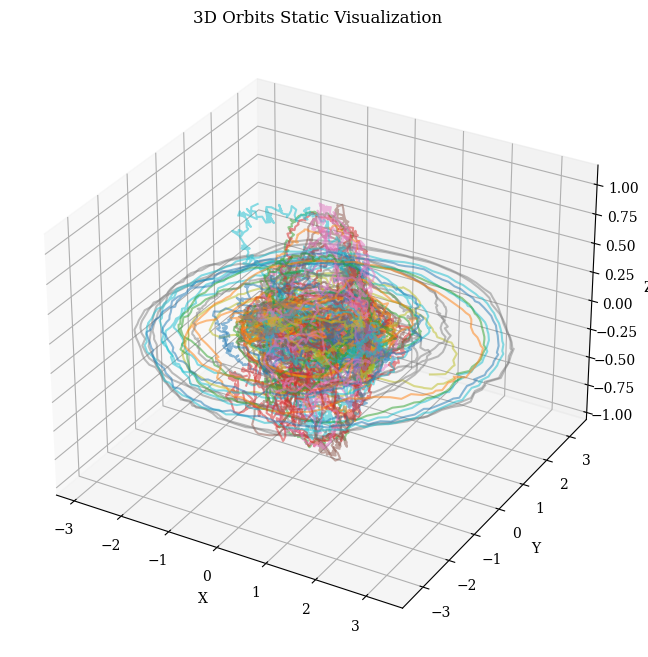

In [21]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

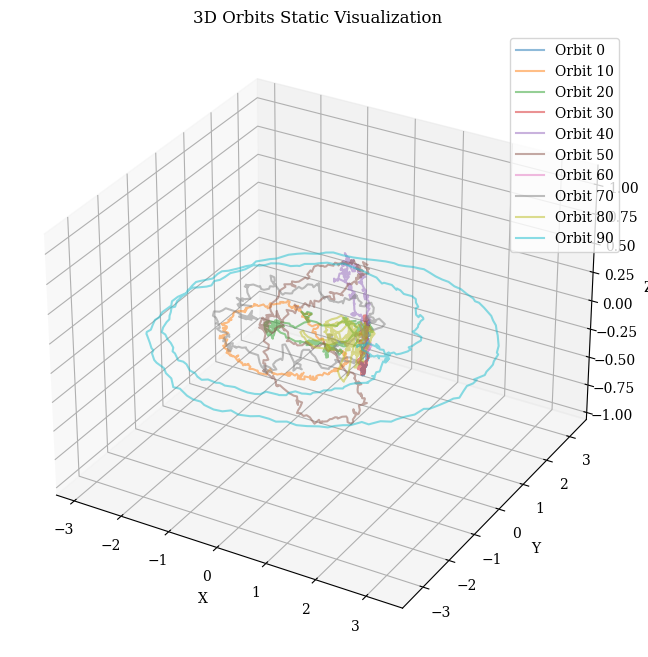

In [22]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,40,50,60,70,80,90], save_path=static_some_orbit_path)

In [23]:
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_1/exp1_generated_orbits.html


## Coverage

In [24]:
data.shape

(45211, 7, 300)

In [25]:
inverted_ordered_generation = np.transpose(inverted_generation, (0, 2, 1))
inverted_ordered_generation.shape

(100, 7, 300)

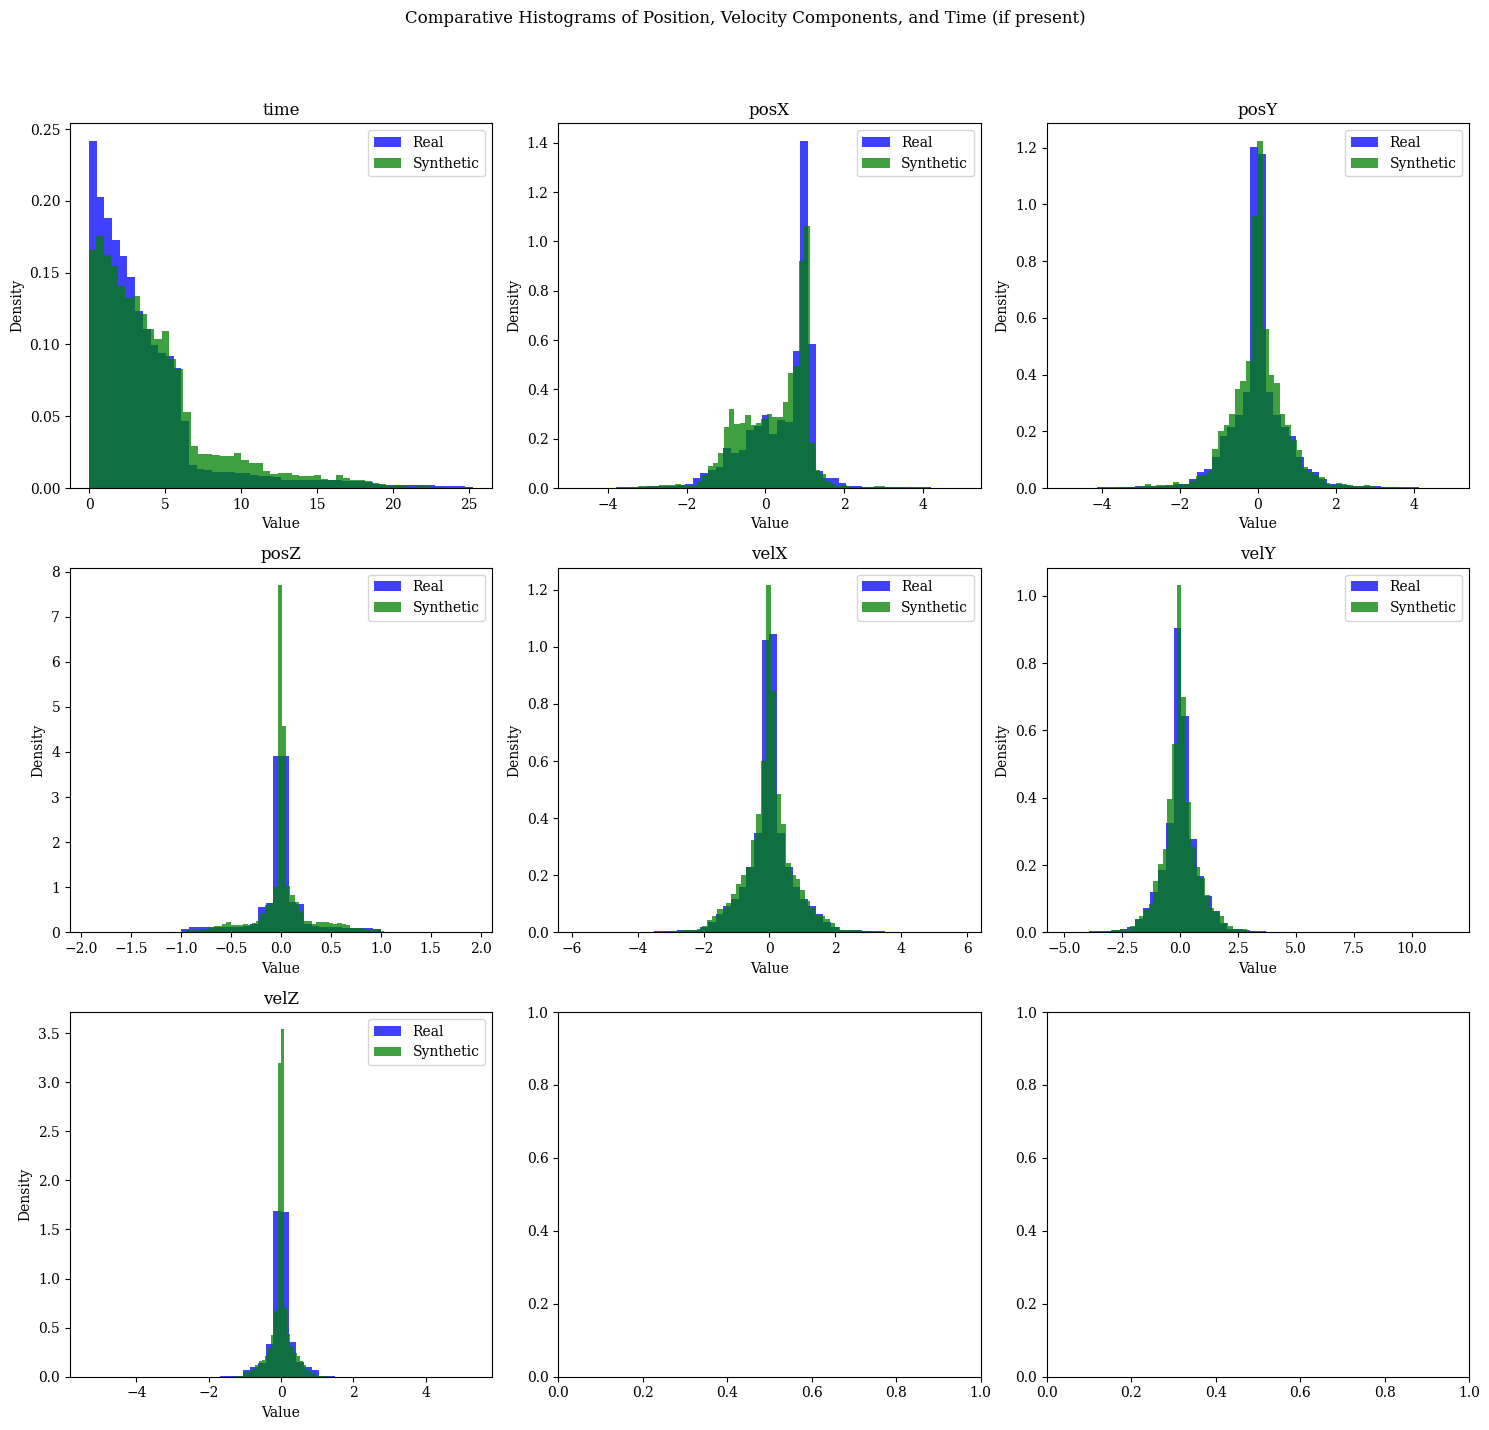

In [26]:
plot_histograms_comparison(data1=data, data2=inverted_ordered_generation, label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 5726.5642759836865
Average position error per time step: 19.152388882888584


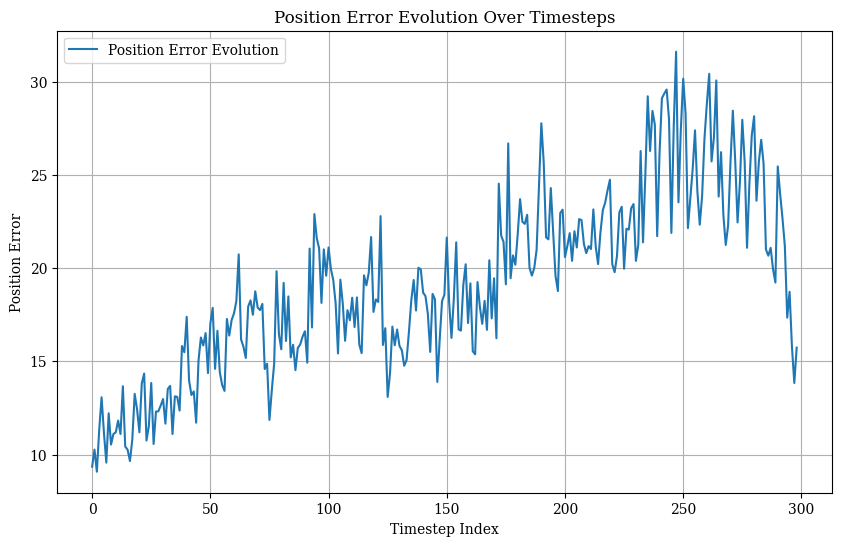

Cumulative velocity error for selected orbits: 8742.169299076853
Average velocity error per time step: 29.23802441162827


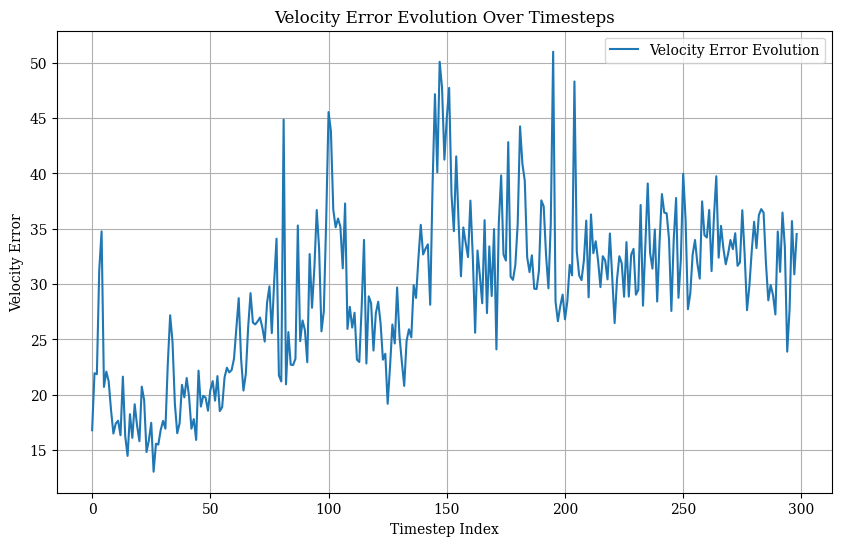

Cumulative energy error for selected orbits: 23646.549984911428
Average energy error per time step: 79.08545145455327


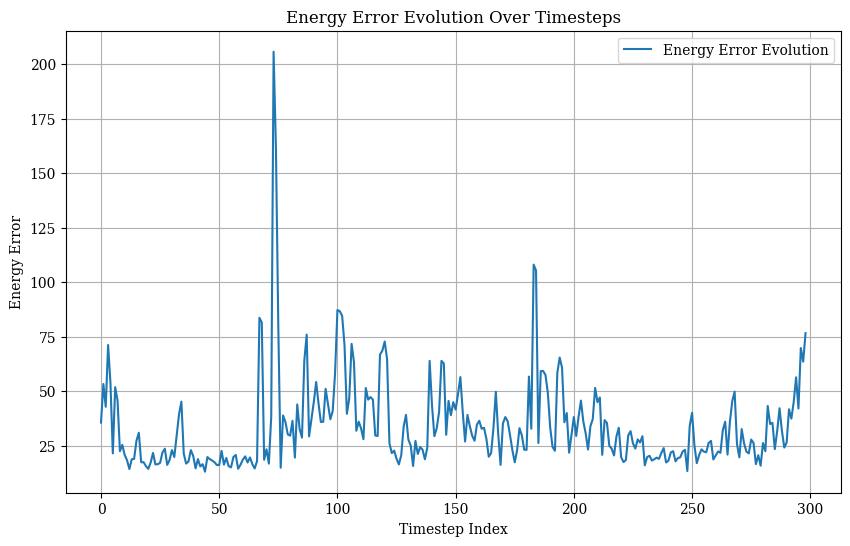

In [27]:
## add model metrics
reordered_orbits, order_metrics = reorder_orbits(inverted_ordered_generation)
errors = calculate_errors(reordered_orbits,EM_MU,time_step=0.01)

In [28]:

# Add order
add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

Metrics added to experiment with ID 1 in ../experiments/experiments.json.


# Latent Visualization

## Sampling

In [29]:
np.random.seed(42)

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=5000, replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(5000, 300, 7)

In [30]:
latent_mean, latent_deviation, latent_epsilon = model.encoder(sampled_data)
sampled_latent_representations = latent_mean.numpy()

np.save(sampled_latent_representations_path, sampled_latent_representations)
np.save(labels_sampled_latent_representations_path, sampled_labels)

sampled_latent_representations.shape

(5000, 2)

In [31]:
sampled_id_classes = [orbit_df.at[index, 'id_class'] for index in sampled_labels]
sampled_classes=get_orbit_classes(sampled_id_classes)

## Orbit Classifications

In [37]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap
from typing import List, Optional, Any
import matplotlib.cm as cm

def reduce_dimensions_plot_latent_space(latent_representations: np.ndarray,  # Precomputed latent representations (numpy array).
                      labels: np.ndarray,                  # Labels for the data points, used for coloring in the plot.
                      techniques: List[str] = ['PCA'],     # Techniques to use for reduction ('PCA', 't-SNE', 'UMAP', 'LDA').
                      n_components: int = 2,               # Number of dimensions to reduce to (1, 2, or 3).
                      figsize: tuple = (12, 9),            # Size of the figure for each subplot.
                      save_path: Optional[str] = None,     # Optional path to save the plot image.
                      many_classes: bool = False,          # Flag to use enhanced plotting for many classes.
                      grid_view: bool = True,              # Flag to plot all techniques in a single grid view.
                      **kwargs: Any                        # Additional keyword arguments for dimensionality reduction methods.
                     ) -> None:
    """
    Plots and optionally saves the latent space representations using specified dimensionality reduction techniques.
    Each technique's plot is handled in a separate figure, supporting 1D, 2D, or 3D visualizations.
    """
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    models = {
        'PCA': PCA(n_components=n_components),
        't-SNE': TSNE(n_components=n_components, **kwargs),
        'UMAP': umap.UMAP(n_components=n_components, **kwargs),
        'LDA': LinearDiscriminantAnalysis(n_components=n_components)
    }

    n_techniques = len(techniques)
    if grid_view:
        fig, axs = plt.subplots(1, n_techniques, figsize=(figsize[0] * n_techniques, figsize[1]))
        if n_techniques == 1:
            axs = [axs]
    else:
        axs = [None] * n_techniques

    # Use a colormap for better color differentiation
    cmap = cm.get_cmap('tab20', len(class_names))  # You can change 'tab20' to any other colormap

    for idx, technique in enumerate(techniques):
        model = models.get(technique)
        if not model:
            continue  # Skip if model not found in dictionary

        if technique == 'LDA':
            results = model.fit_transform(latent_representations, encoded_labels)
        else:
            results = model.fit_transform(latent_representations)

        if n_components == 3:
            if grid_view:
                ax = fig.add_subplot(1, n_techniques, idx+1, projection='3d')
            else:
                fig = plt.figure(figsize=figsize)
                ax = fig.add_subplot(111, projection='3d')
        else:
            ax = axs[idx] if grid_view else plt.subplots(figsize=figsize)[1]

        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap(class_idx)
            if n_components == 1:
                ax.scatter(results[class_mask], np.zeros_like(results[class_mask]), label=class_name, color=color, s=30)
            elif n_components == 2:
                ax.scatter(results[class_mask, 0], results[class_mask, 1], label=class_name, color=color, s=30)
            elif n_components == 3:
                ax.scatter(results[class_mask, 0], results[class_mask, 1], results[class_mask, 2], label=class_name, color=color, s=30)
        
        ax.legend(title="Classes")

        ax.set_title(f'Visualization with {technique}')
        if n_components == 1:
            ax.set_xlabel(f'{technique} Component 1')
        elif n_components == 2:
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
        elif n_components == 3:
            ax.set_xlabel(f'{technique} Dimension 1')
            ax.set_ylabel(f'{technique} Dimension 2')
            ax.set_zlabel(f'{technique} Dimension 3')

        if not grid_view:
            if save_path:
                individual_save_path = f"{save_path}_{technique}.png"
                plt.savefig(individual_save_path, bbox_inches='tight')
                print(f"Saved plot to {individual_save_path}")
            plt.show()

    if grid_view:
        plt.tight_layout()
        if save_path:
            grid_save_path = f"{save_path}_grid.png"
            plt.savefig(grid_save_path, bbox_inches='tight')
            print(f"Saved grid plot to {grid_save_path}")
        plt.show()


/tmp/ipykernel_950039/2248952422.py:47: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_label_PCA.png


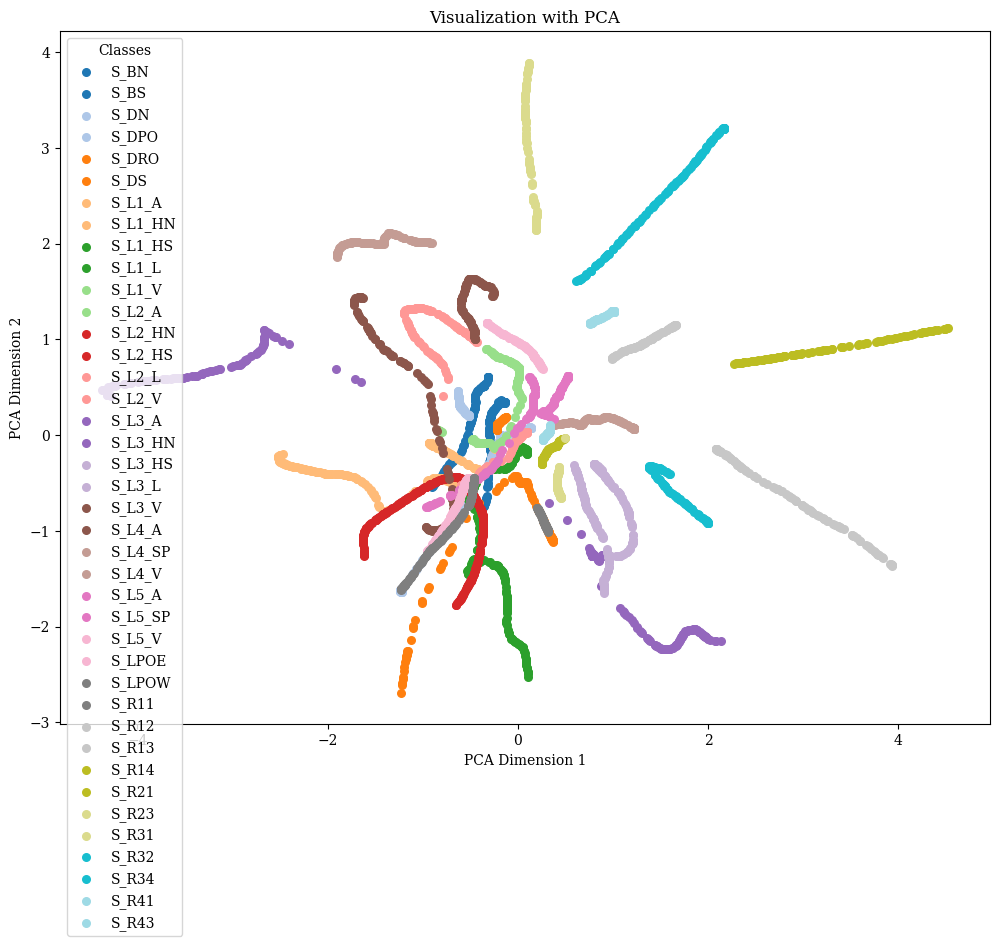

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_label_t-SNE.png


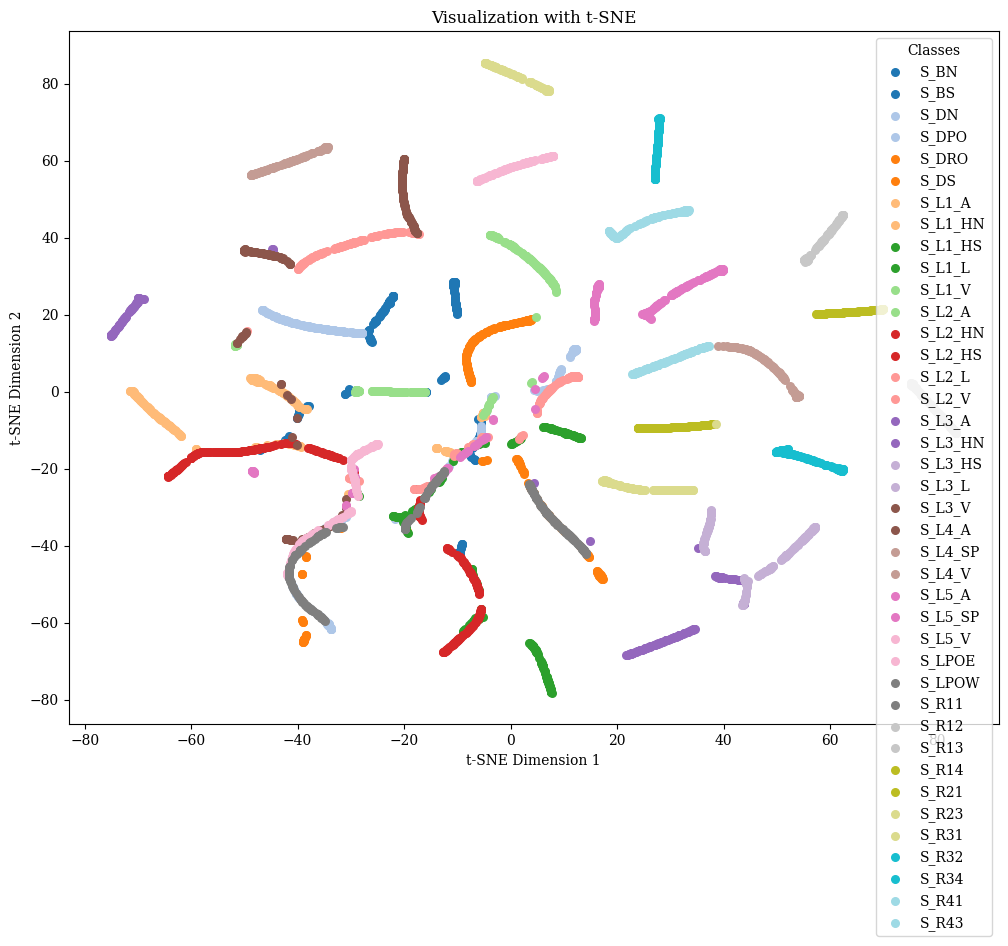

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_label_UMAP.png


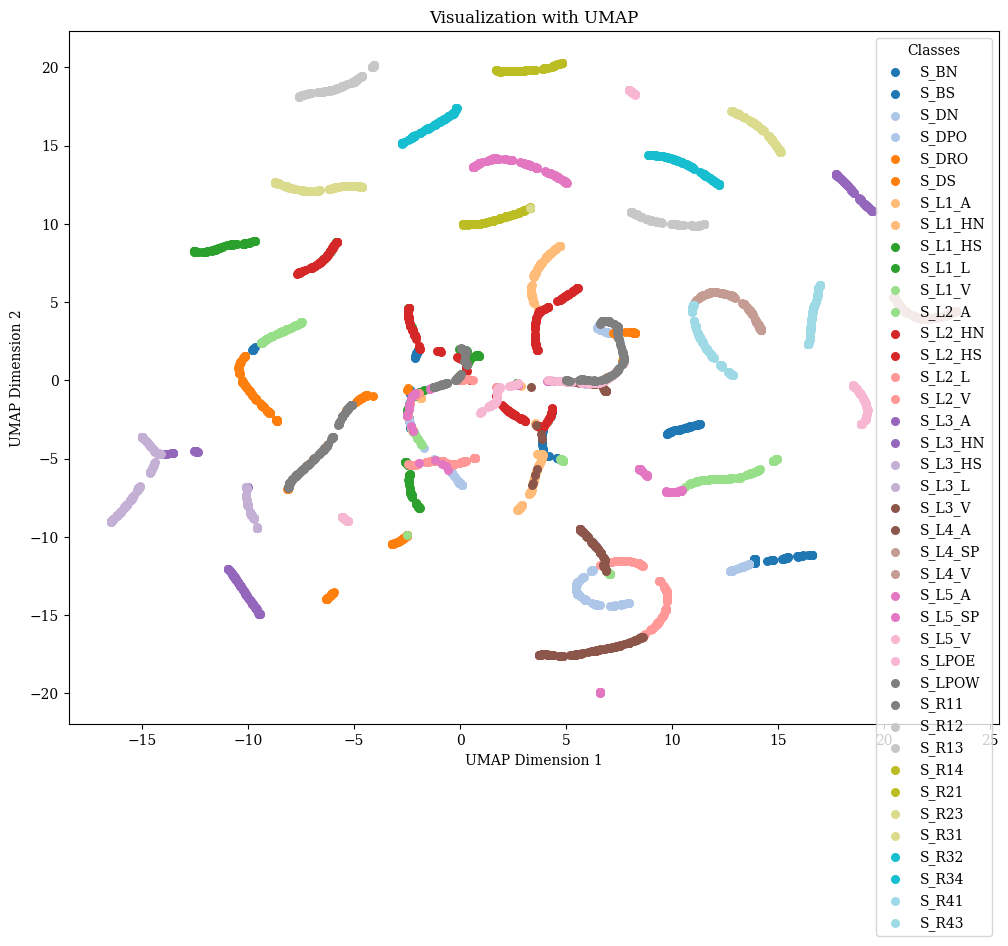

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_label_LDA.png


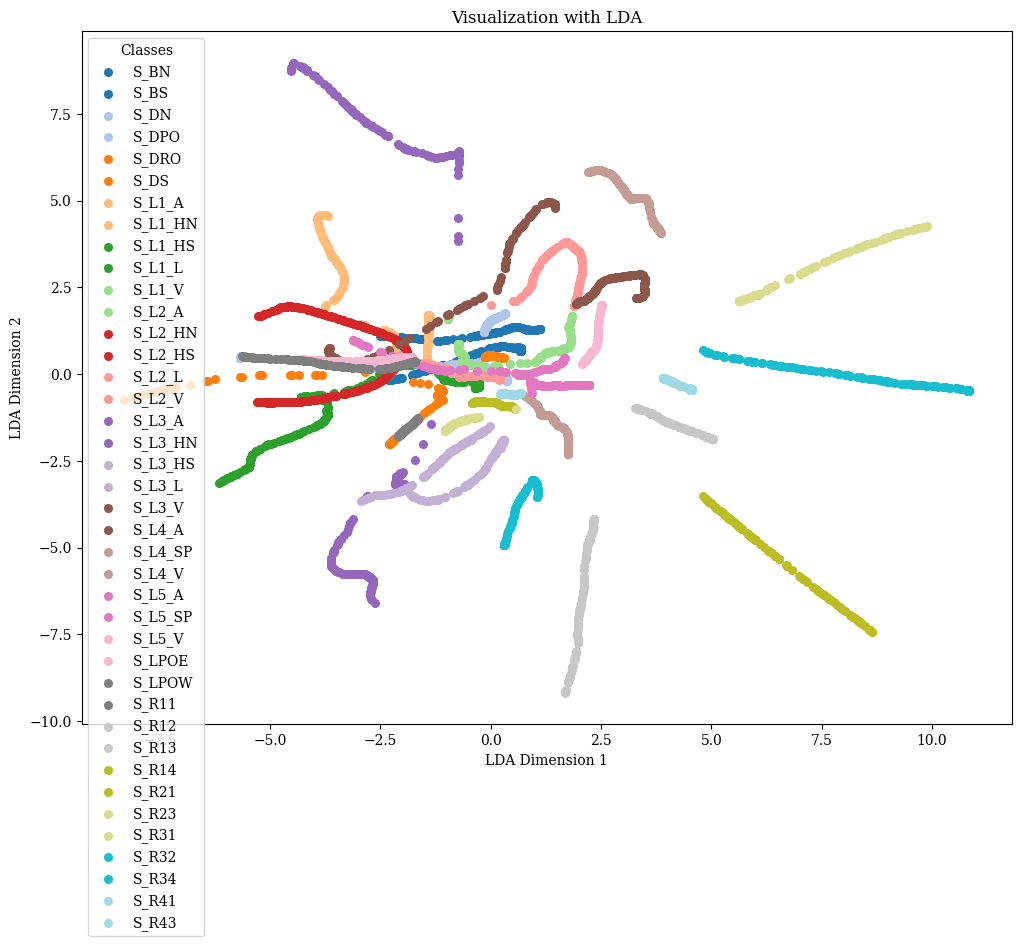

In [38]:
reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[0]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_label', many_classes=True, grid_view=False)

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_label


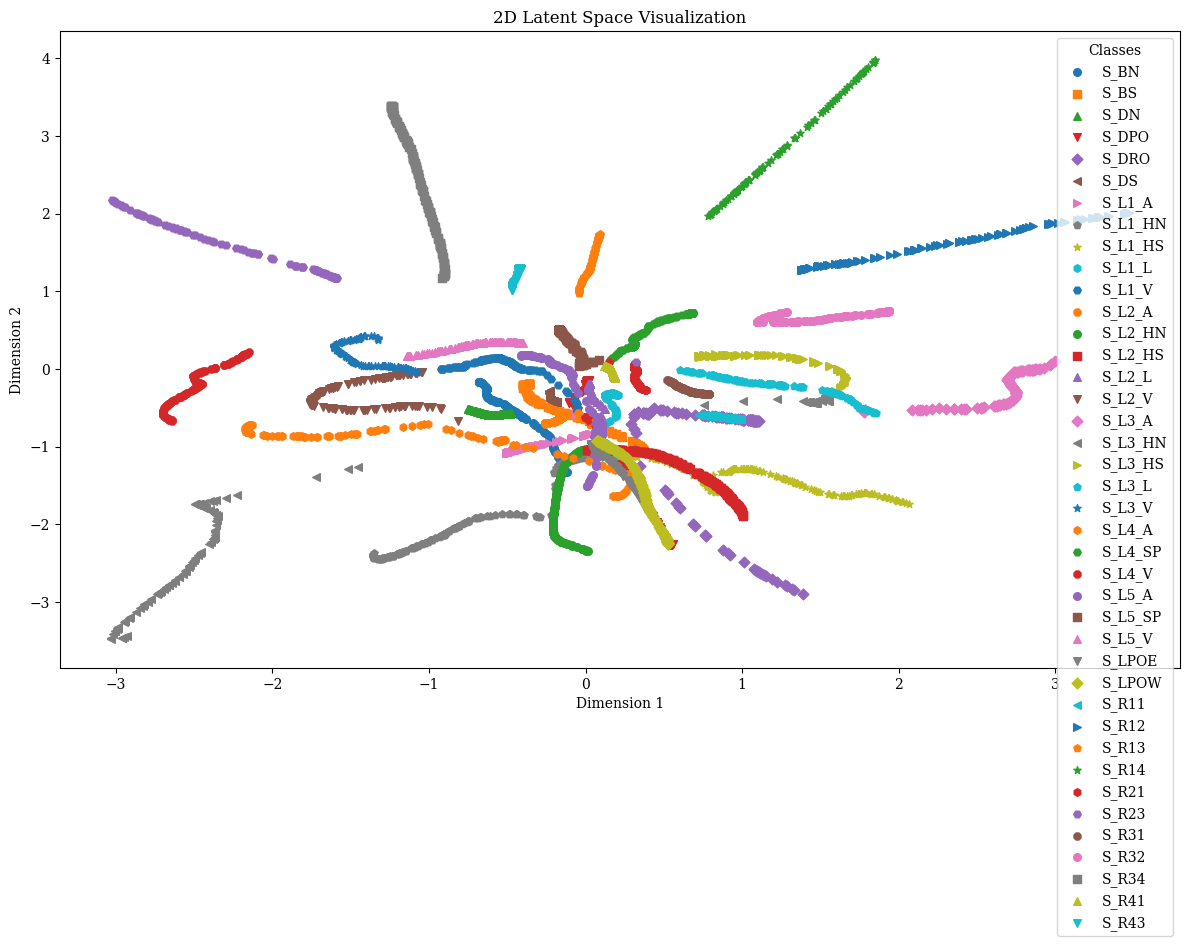

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_type


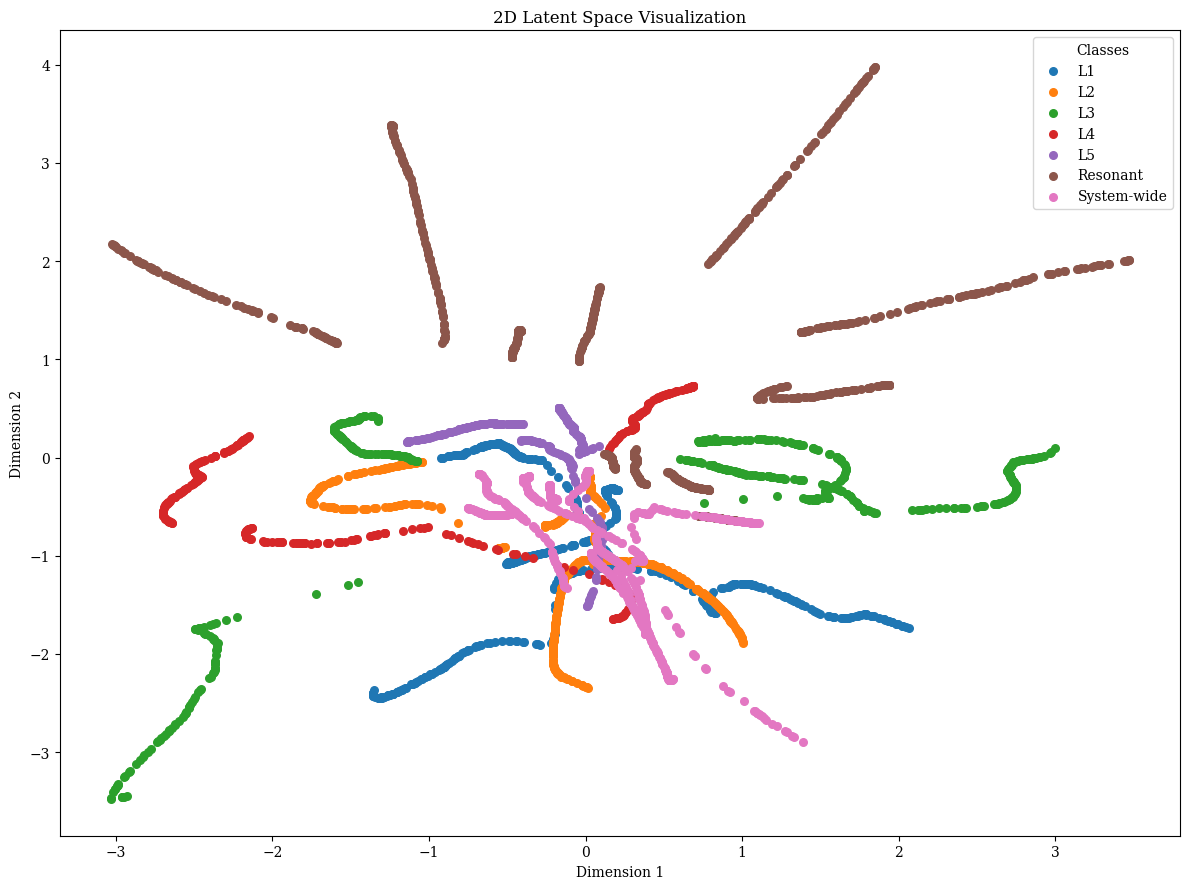

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_subtype


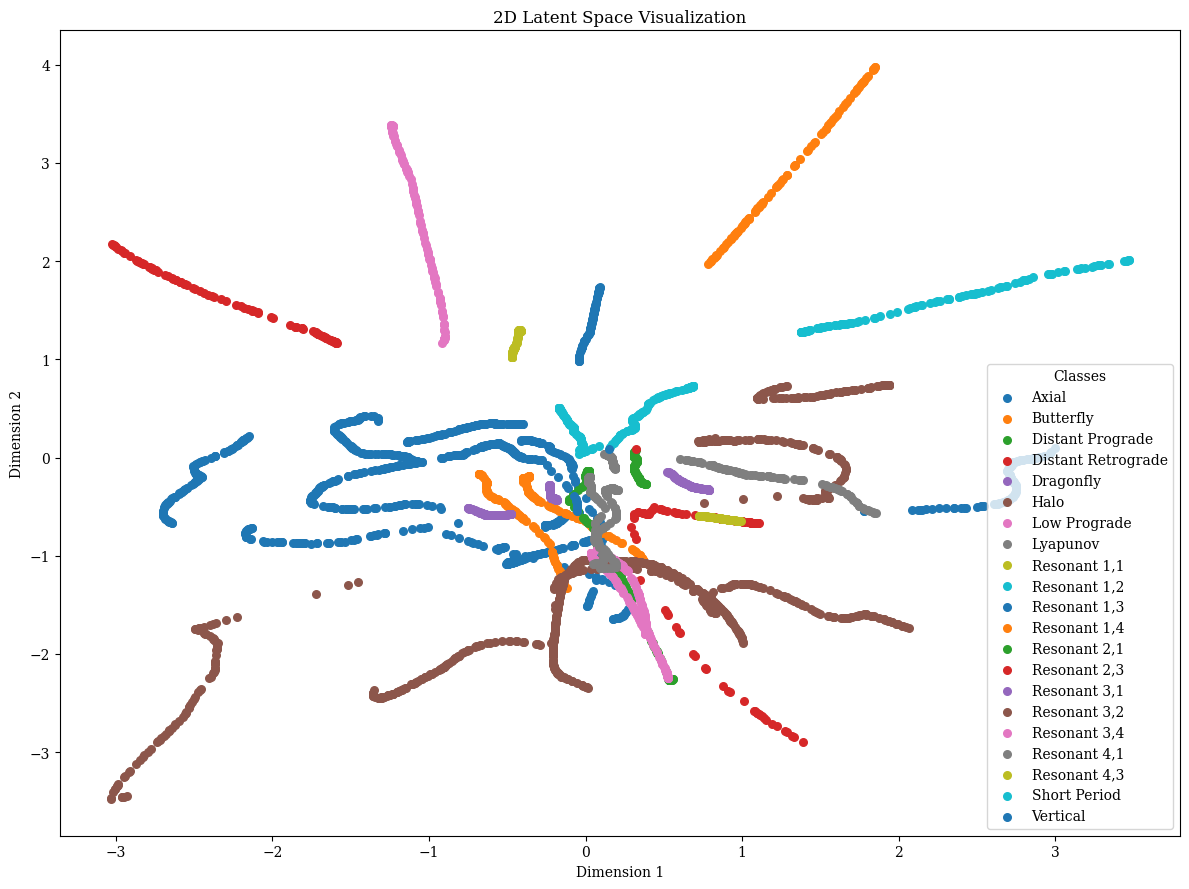

Saved plot to ../experiments/experiment_1/exp1_dimensionality_reduction_latent_space_direction


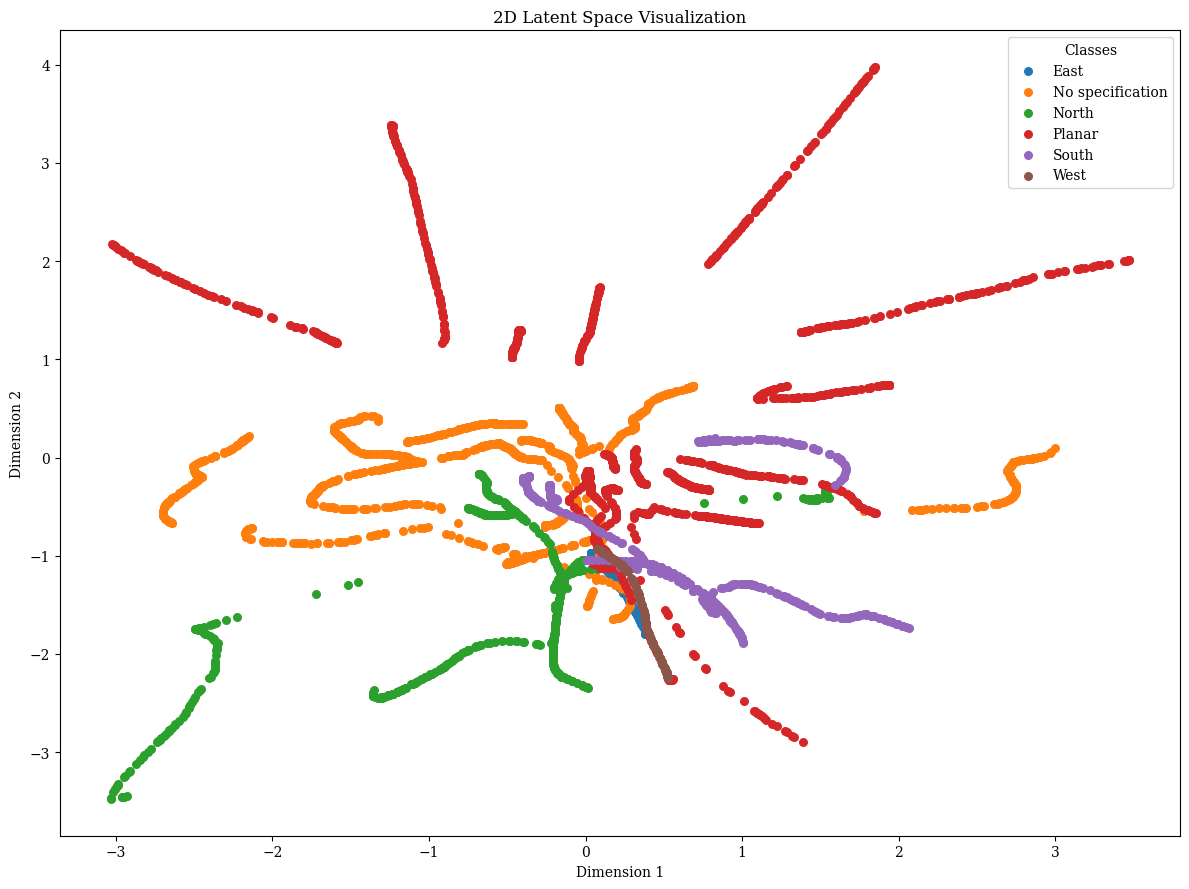

In [32]:
if sampled_latent_representations.shape[1]==2:
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[0]), save_path=latent_space_path +'_label', many_classes=True)
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[1]), save_path=latent_space_path +'_type')
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[2]), save_path=latent_space_path +'_subtype')
    plot_latent_space_2d(sampled_latent_representations, np.array(sampled_classes[3]), save_path=latent_space_path +'_direction')
else:
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[0]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_label', many_classes=True, grid_view=False)
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[1]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_type')
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[2]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_subtype')
    reduce_dimensions_plot_latent_space(sampled_latent_representations, np.array(sampled_classes[3]), techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path +'_direction')

In [33]:
wandb.finish()

TypeError: field() got an unexpected keyword argument 'alias'

In [ ]:
# Save notebook as experiment
notebook_path = '/orbit-generation/nbs_experiments/01_cvae.ipynb'  # Update this to the path of your notebook
convert_notebook(notebook_path, experiment_folder, os.path.basename(experiment_folder), format='html')

An error occurred while converting the notebook to HTML:
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 5, in <module>
    from nbconvert.nbconvertapp import main
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/__init__.py", line 6, in <module>
    from . import filters, postprocessors, preprocessors, writers
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/__init__.py", line 8, in <module>
    from .markdown import (
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/markdown.py", line 12, in <module>
    from .markdown_mistune import markdown2html_mistune
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/markdown_mistune.py", line 21, in <module>
    from nbconvert.filters.strings import add_anchor
  File "/usr/local/lib/python3.8/dist-packages/nbconvert/filters/strings.py", line 23, in <module>
    from nbconvert.preprocessors.sanitize import _get_default_css_sanitizer
  File "/usr/local/lib/py

CalledProcessError: Command 'jupyter nbconvert --to html "/orbit-generation/nbs_experiments/01_cvae.ipynb" --output "../experiments/experiment_3/experiment_3.html"' returned non-zero exit status 1.